In [1]:
%matplotlib inline

# Chapter 3
## What can we Learn form the Data?

### Preparing data
We just load the diabetes dataset and apply the cleaning we did on zero BMI entries in the last chapter and the data we'll be ready to move forward with our inferential analysis in this chapter.

In [2]:
import pandas as pd

data = pd.read_csv('../datasets/PimaIndiansDiabetes.csv')
data_of_interest = data.loc[:, ["BMI", "Class"]]

zero_bmi_mask = data_of_interest.loc[:, "BMI"] != 0

clean_data_of_interest = data_of_interest[zero_bmi_mask]

### Weighting histograms with `sample_size`

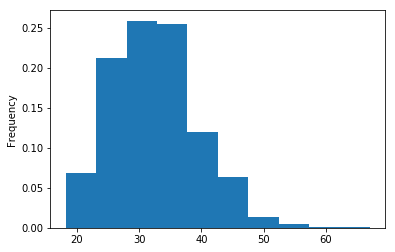

In [3]:
sample_size = len(clean_data_of_interest.loc[:, "BMI"])
weights_list = [1 / sample_size] * sample_size

clean_data_of_interest.loc[:, "BMI"].plot.hist(weights=weights_list)

### Plotting probability density

Text(0,0.5,'Probability Desnity')

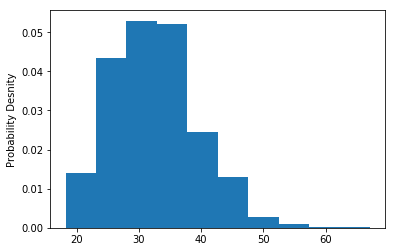

In [4]:
clean_data_of_interest.loc[:, "BMI"].plot.hist(normed=True).set_ylabel("Probability Desnity")

### Implementing a Bernoulli distribution

In [5]:
def bernoulli(y, p):
    return y * p + (1 - y) * (1 - p)

In [6]:
print("Probability of getting a 0 from a Bernoulli(0.457): {:.2f}". format(bernoulli(0, 0.457)))
print("Probability of getting a 1 from a Bernoulli(0.963): {:.2f}". format(bernoulli(1, 0.963)))

Probability of getting a 0 from a Bernoulli(0.457): 0.54
Probability of getting a 1 from a Bernoulli(0.963): 0.96


### `scipy` distributions: functional vs. object-oriented

#### Functional form



In [7]:
from scipy.stats import norm

functional_cdf_at_3 = norm.cdf(3, loc=1, scale=2.5)

In [8]:
print("{:.4f}".format(functional_cdf_at_3))

0.7881


#### Object-oriented

In [9]:
rv = norm(loc=1, scale=2.5)
oo_cdf_at_3 = rv.cdf(3)

In [10]:
print("{:.4f}".format(oo_cdf_at_3))

0.7881


### Inferring the relation between lifestyle and diabtes

#### Splitting the data into diabetics and non-diabetics

In [11]:
diabetics_mask = clean_data_of_interest.loc[:, "Class"] == 1
diabetics = clean_data_of_interest[diabetics_mask]
non_diabetics = clean_data_of_interest[~diabetics_mask]

#### Plotting the BMI histograms and density estimation in ecah group

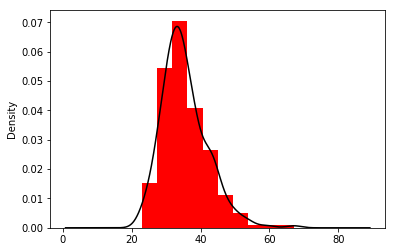

In [12]:
diabetics.loc[:, "BMI"].plot.hist(color='red', normed=True)
diabetics.loc[:, "BMI"].plot.density(color='black')

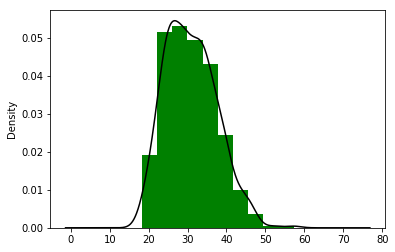

In [13]:
non_diabetics.loc[:, "BMI"].plot.hist(color='green', normed=True)
non_diabetics.loc[:, "BMI"].plot.density(color='black')

#### Implementing the Bayes rule

In [14]:
# calculating the distributions parameters

# X ~ N(mean_X, (std_X)**2)
mean_X = clean_data_of_interest.loc[:, "BMI"].mean()
std_X = clean_data_of_interest.loc[:, "BMI"].std()

# Y ~ Bernoulli(mean_Y)
mean_Y = clean_data_of_interest.loc[:, "Class"].mean()

# X|Y=y ~ N(y * mean_1 + (1 - y) * mean_0, y * (std_1 ** 2) + (1 - y) * (std_0 ** 2))
mean_1 = diabetics.loc[:, "BMI"].mean()
std_1 = diabetics.loc[:, "BMI"].std()
mean_0 = non_diabetics.loc[:, "BMI"].mean()
std_0 = non_diabetics.loc[:, "BMI"].mean()

In [15]:
from scipy.stats import bernoulli

def P(y, rel, x):
    # rel is a either '>' or '<', i.e. the relation between X and the value x
    
    P_Y = bernoulli.pmf(y, p=mean_Y)
    
    mean_X_given_Y = y * mean_1 + (1 - y) * mean_0
    std_X_given_Y = y * std_1 + (1 - y) * std_0
    P_X_given_Y = norm.cdf(x, loc=mean_X_given_Y, scale=std_X_given_Y)
    
    P_X = norm.cdf(x, loc=mean_X, scale=std_X)
    
    if rel == '>':
        P_X_given_Y = 1 - P_X_given_Y
        P_X = 1 - P_X
        
    return P_X_given_Y * P_Y / P_X

#### Doing inference with the Bayes rule

In [16]:
print("P(Y = 1 | X ≥ 30) = {:.2f}".format(P(1, '>', 30)))
print("P(Y = 1 | X < 30) = {:.2f}".format(P(1, '<', 30)))

P(Y = 1 | X ≥ 30) = 0.44
P(Y = 1 | X < 30) = 0.20


_**Inference**: having a BMI higher than or equal 30 (indicating poor lifestyle) doubles the chances of having diabetes_

In [17]:
print("P(Y = 0 | X ≥ 30) = {:.2f}".format(P(0, '>', 30)))
print("P(Y = 0 | X < 30) = {:.2f}".format(P(0, '<', 30)))

P(Y = 0 | X ≥ 30) = 0.52
P(Y = 0 | X < 30) = 0.88


_**Inference**: having a BMI higher than or equal 30 (indicating poor lifestyle) reduces the chances of being helathy by around 40%_